In [87]:
# Import libraries

import pandas as pd
import json
from sentence_transformers import SentenceTransformer
from elasticsearch import Elasticsearch
from openai import OpenAI
from tqdm import tqdm, trange
import random
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read JSON document with generated ids

with open('..\data\data-with-ids.json', 'rt') as f_in:
    documents = json.load(f_in)

In [3]:
doc_idx = {d['id']: d for d in documents}

In [4]:
# Ground truth data

df_questions = pd.read_csv('..\data\ground-truth-retrieval.csv')
ground_truth = df_questions.to_dict(orient='records')

In [5]:
model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

In [6]:
es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "question": {"type": "text"},
            "answer": {"type": "text"},
            "source": {"type": "text"},
            "focus_area": {"type": "text"},
            "id": {"type": "keyword"},
            "question_answer_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            }
        }
    }
}

index_name = "health-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'health-questions'})

In [7]:
for doc in tqdm(documents):
    question = doc['question']
    answer = doc['answer']  
    
    qa = question + ' ' + answer    
    doc['question_answer_vector'] = model.encode(qa)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 292/292 [01:54<00:00,  2.54it/s]


In [8]:
for doc in tqdm(documents):
    es_client.index(index=index_name, document=doc)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 292/292 [00:48<00:00,  6.06it/s]


In [9]:
def elastic_search_knn(field, vector):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000}

    search_query = {
        "knn": knn,
        "_source": ["question", "answer", "source", "focus_area", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

In [10]:
def qa_vector_knn(q):
    question = q['question']
    v_q = model.encode(question)
    return elastic_search_knn('question_answer_vector', v_q)

In [11]:
def hit_rate(relevance_total):
    cnt = 0

    for line in relevance_total:
        if True in line:
            cnt = cnt + 1

    return cnt / len(relevance_total)

In [12]:
def mrr(relevance_total):
    total_score = 0.0

    for line in relevance_total:
        for rank in range(len(line)):
            if line[rank] == True:
                total_score = total_score + 1 / (rank + 1)

    return total_score / len(relevance_total)

In [13]:
def evaluate(ground_truth, search_function):
    relevance_total = []

    for q in tqdm(ground_truth):
        doc_id = q['id']
        results = search_function(q)
        relevance = [d['id'] == doc_id for d in results]
        relevance_total.append(relevance)

    return {
        'hit_rate': hit_rate(relevance_total),
        'mrr': mrr(relevance_total),
    }

In [84]:
evaluate(ground_truth, qa_vector_knn)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1460/1460 [06:08<00:00,  3.97it/s]


{'hit_rate': 0.9849315068493151, 'mrr': 0.9551027397260271}

In [14]:
# Define a function that creates a prompt for an LLM to answer health-related questions based on the given data

def build_prompt(query, search_results):
    prompt_template = """
You're a healthcare assistant AI. Answer the QUESTION based on the CONTEXT provided from a health FAQ database.
Use only the facts from the CONTEXT to provide an accurate, clear, and concise answer.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context += f"Question: {doc['question']}\nAnswer: {doc['answer']}\nSource: {doc['source']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [15]:
client = OpenAI()

def llm(prompt, model='gpt-4o-mini'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [16]:
def rag(query_dict, model='gpt-4o-mini'):
    # Extract the question from the input dictionary
    question = query_dict['question']  
    search_results = qa_vector_knn(query_dict) 
    prompt = build_prompt(question, search_results)
    answer = llm(prompt, model=model) 
    return answer

### **RAG Evaluation**

In [17]:
ground_truth[100]

{'id': '32512413',
 'question': 'What are the tests used to diagnose anal cancer?'}

In [18]:
orig_ans = doc_idx['32512413']['answer']
orig_ans

'Tests that examine the rectum and anus are used to detect (find) and diagnose anal cancer. The following tests and procedures may be used:         -   Physical exam and history : An exam of the body to check general signs of health, including checking for signs of disease, such as lumps or anything else that seems unusual. A history of the patients health habits and past illnesses and treatments will also be taken.    -   Digital rectal examination (DRE): An exam of the anus and rectum. The doctor or nurse inserts a lubricated, gloved finger into the lower part of the rectum to feel for lumps or anything else that seems unusual.    -  Anoscopy: An exam of the anus and lower rectum using a short, lighted tube called an anoscope.     -   Proctoscopy : An exam of the rectum using a short, lighted tube called a proctoscope.    -  Endo-anal or endorectal ultrasound : A procedure in which an ultrasound transducer (probe) is inserted into the anus or rectum and used to bounce high-energy sou

In [19]:
llm_ans = rag(ground_truth[100])
llm_ans

'To diagnose anal cancer, several tests and procedures may be used, including:\n\n1. **Physical exam and history**: Checking general health signs and past medical history.\n2. **Digital rectal examination (DRE)**: A doctor or nurse inserts a lubricated, gloved finger into the rectum to check for lumps or unusual sensations.\n3. **Anoscopy**: Examining the anus and lower rectum with a lighted tube called an anoscope.\n4. **Proctoscopy**: Viewing the rectum with a lighted tube called a proctoscope.\n5. **Endo-anal or endorectal ultrasound**: Using an ultrasound probe inserted into the anus or rectum to create images of internal tissues.\n6. **Biopsy**: Removing cells or tissues for microscopic examination, often performed if abnormalities are detected during other tests.\n\nThese methods help in detecting and diagnosing anal cancer effectively.'

#### Cosine Similarity

In [20]:
v_llm = model.encode(llm_ans)
v_orig = model.encode(orig_ans)

v_llm.dot(v_orig)

0.88482976

In [21]:
from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

#### *GPT-3.5-turbo*

In [22]:
def process_record(rec):
    model = 'gpt-3.5-turbo'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['id']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['answer']

    return {
        'question': rec['question'],
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'id': doc_id,
    }

In [23]:
process_record(ground_truth[100])

{'question': 'What are the tests used to diagnose anal cancer?',
 'answer_llm': 'Tests used to diagnose anal cancer include a physical exam, digital rectal examination, anoscopy, proctoscopy, endo-anal or endorectal ultrasound, and biopsy.',
 'answer_orig': 'Tests that examine the rectum and anus are used to detect (find) and diagnose anal cancer. The following tests and procedures may be used:         -   Physical exam and history : An exam of the body to check general signs of health, including checking for signs of disease, such as lumps or anything else that seems unusual. A history of the patients health habits and past illnesses and treatments will also be taken.    -   Digital rectal examination (DRE): An exam of the anus and rectum. The doctor or nurse inserts a lubricated, gloved finger into the lower part of the rectum to feel for lumps or anything else that seems unusual.    -  Anoscopy: An exam of the anus and lower rectum using a short, lighted tube called an anoscope.    

In [24]:
df_sample = df_questions.sample(n=50, random_state=1)
sample = df_sample.to_dict(orient='records')

In [39]:
results_gpt35 = map_progress(pool, sample, process_record)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.38it/s]


In [48]:
df_gpt35 = pd.DataFrame(results_gpt35)
df_gpt35.to_csv('../data/results-gpt35.csv', index=False)

In [40]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [49]:
results_gpt35 = df_gpt35.to_dict(orient='records')

similarity_35 = []

for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity_35.append(sim)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.03it/s]


In [50]:
df_gpt35['cosine'] = similarity_35
df_gpt35['cosine'].describe()

count    50.000000
mean      0.670119
std       0.163142
min       0.200066
25%       0.537733
50%       0.708327
75%       0.806253
max       0.950200
Name: cosine, dtype: float64

#### *GPT-4o-mini*

In [28]:
def process_record_4o_mini(rec):
    model = 'gpt-4o-mini'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['id']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['answer']

    return {
        'question': rec['question'],
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'id': doc_id,
    }

In [29]:
process_record_4o_mini(ground_truth[100])

{'question': 'What are the tests used to diagnose anal cancer?',
 'answer_llm': 'To diagnose anal cancer, several tests and procedures may be used, including:\n\n- **Physical exam and history**: Checking general health signs, including lumps or unusual findings.\n- **Digital rectal examination (DRE)**: A doctor or nurse inserts a lubricated, gloved finger into the rectum to feel for abnormalities.\n- **Anoscopy**: Examination of the anus and lower rectum using a lighted tube called an anoscope.\n- **Proctoscopy**: Examination of the rectum using a lighted tube called a proctoscope.\n- **Endo-anal or endorectal ultrasound**: An ultrasound probe is inserted into the anus or rectum to create a sonogram.\n- **Biopsy**: Removal of tissue or cells for microscopic examination to check for cancer signs.\n\nThese procedures help detect and confirm the presence of anal cancer.',
 'answer_orig': 'Tests that examine the rectum and anus are used to detect (find) and diagnose anal cancer. The follow

In [30]:
results_gpt4mini = map_progress(pool, sample, process_record_4o_mini)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.02it/s]


In [51]:
df_gpt4o_mini = pd.DataFrame(results_gpt4mini)
df_gpt4o_mini.to_csv('../data/results-gpt4o-mini.csv', index=False)

In [52]:
results_gpt4omini = df_gpt4o_mini.to_dict(orient='records')

In [53]:
similarity_4o_mini = []

for record in tqdm(results_gpt4omini):
    sim = compute_similarity(record)
    similarity_4o_mini.append(sim)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.92it/s]


In [55]:
df_gpt4o_mini['cosine'] = similarity_4o_mini
df_gpt4o_mini['cosine'].describe()

count    50.000000
mean      0.728357
std       0.116234
min       0.491954
25%       0.644682
50%       0.742230
75%       0.823760
max       0.957333
Name: cosine, dtype: float64

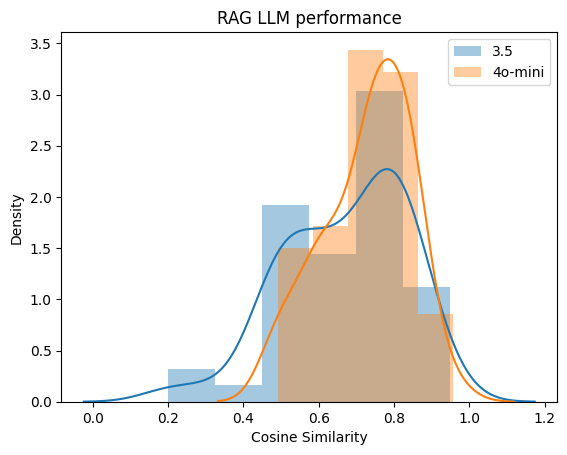

In [88]:
# Plot RAG LLM performance
sns.distplot(df_gpt35['cosine'], label='3.5')
sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')

plt.title("RAG LLM performance")
plt.xlabel("Cosine Similarity")
plt.legend();

GPT-4o-mini outperforms GPT-3.5-turbo

### LLM as a judge

In [61]:
prompt2_template = """
You are an expert evaluator for a RAG system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [78]:
evaluations = []

for record in tqdm(sample):
    question = record['question']
    answer_llm = rag({'question': question}) 
    prompt = prompt2_template.format(
        question=question,
        answer_llm=answer_llm
    )

    # Send the prompt to another LLM for evaluation
    evaluation = llm(prompt)
    evaluation = json.loads(evaluation) 
    
    evaluations.append({
        'record': record,
        'answer_llm': answer_llm,
        'evaluation': evaluation
    })


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:33<00:00,  4.27s/it]


In [79]:
evaluations[0]

{'record': {'id': '2d2954c8',
  'question': 'What should I do if I still experience symptoms after adopting a strict gluten-free diet?'},
 'answer_llm': 'If you continue to experience symptoms after adopting a strict gluten-free diet, it is important to consult with a healthcare provider. Some potential reasons for persistent symptoms may include consuming hidden sources of gluten, such as additives in medications and nonfood products, or the presence of other conditions commonly associated with celiac disease, such as small intestinal bacterial overgrowth, pancreatic exocrine insufficiency, microscopic colitis, irritable bowel syndrome (IBS), lactose intolerance, or other food intolerances. You may also be experiencing refractory celiac disease, where the intestines remain severely damaged and cannot heal, requiring further medical evaluation and possibly intravenous nutrient administration.',
 'evaluation': {'Relevance': 'RELEVANT',
  'Explanation': 'The generated answer directly add

In [80]:
df_eval = pd.DataFrame(evaluations, columns=['record', 'answer', 'evaluation'])

df_eval['id'] = df_eval.record.apply(lambda d: d['id'] if isinstance(d, dict) else None)
df_eval['question'] = df_eval.record.apply(lambda d: d['question'] if isinstance(d, dict) else None)

df_eval['relevance'] = df_eval.evaluation.apply(lambda d: d['Relevance'] if isinstance(d, dict) else None)
df_eval['explanation'] = df_eval.evaluation.apply(lambda d: d['Explanation'] if isinstance(d, dict) else None)

del df_eval['record']
del df_eval['evaluation']

In [81]:
df_eval.relevance.value_counts(normalize=True)

relevance
RELEVANT           0.88
PARTLY_RELEVANT    0.06
NON_RELEVANT       0.06
Name: proportion, dtype: float64

Better performance using vectors

In [82]:
df_eval[df_eval.relevance == 'NON_RELEVANT']

,answer,id,question,relevance,explanation
14,NaN,c1abe560,What are the best treatment options available ...,NON_RELEVANT,The generated answer states that it cannot pro...
21,NaN,cd440cb8,How does Williams syndrome affect cognitive de...,NON_RELEVANT,The generated answer does not address the ques...
44,NaN,8010eef7,Are there lifestyle choices that can help redu...,NON_RELEVANT,The generated answer states that there is no i...


In [83]:
df_eval.to_csv('../data/rag-eval-gpt-4o-mini.csv', index=False)